
# **Predicting Calories Burned  Model Trainning.**


**Introduction**

Objective :
This Project Aims to Predict the number of Calarioes Burned By Indivituals Based on their Phyiscal Activity Data Captured By Fitness Trackers.The Data Set includes Features Such as step counts,distance covered at various intensity levels,and time spent in different activity modes.

**DataSet Overview**
1.  source:Fitness Tracker Records.
2.  Samples:940 Daily Records.
3.  Features:15 Columns Including User ID,Date,activity Metrics and Calories Burned .
4.  Target Variable:Calarios




In [22]:
##Import Required Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RND = 42

# Small helper for evaluation
def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Plotting helper
def plot_true_vs_pred(y_true, y_pred, title=None):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()],[y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Calories')
    plt.ylabel('Predicted Calories')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

**ExPloratory Data Analysis(EDA)**

1.1 Initial Inspection: The Dataset Cotains Numerical And Date time features.Key Observations;
1.   No Duplicate Records Found.
2.   Mixed Data Types Requiring Preposessing.
3.   ActivityDate Stored As a Object Type.





In [23]:
##Load and Inspect Data & EDA
df = pd.read_csv('/content/dailyActivity_merged.csv')
print("Dataset shape:", df.shape)
df.head()
df.info()
df.describe()

Dataset shape: (457, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        457 non-null    int64  
 1   ActivityDate              456 non-null    object 
 2   TotalSteps                451 non-null    float64
 3   TotalDistance             453 non-null    float64
 4   TrackerDistance           448 non-null    float64
 5   LoggedActivitiesDistance  456 non-null    float64
 6   VeryActiveDistance        457 non-null    float64
 7   ModeratelyActiveDistance  453 non-null    float64
 8   LightActiveDistance       453 non-null    float64
 9   SedentaryActiveDistance   457 non-null    float64
 10  VeryActiveMinutes         457 non-null    int64  
 11  FairlyActiveMinutes       456 non-null    float64
 12  LightlyActiveMinutes      453 non-null    float64
 13  SedentaryMinutes          456 non-null  

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,4.570000e+02,451.000000,453.000000,448.000000,456.000000,457.000000,453.000000,453.000000,457.000000,457.000000,456.000000,453.000000,456.000000,452.000000
mean,4.628595e+09,6490.944568,4.637417,4.570089,0.179821,1.180897,0.473554,2.884216,0.001904,16.623632,13.098684,168.997792,994.464912,2186.519912
std,2.293781e+09,5388.124125,4.085095,4.055824,0.850123,2.487159,0.829153,2.244013,0.008487,28.919704,36.243213,121.728363,336.937792,815.899078
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000
25%,2.347168e+09,1968.000000,1.360000,1.232500,0.000000,0.000000,0.000000,0.840000,0.000000,0.000000,0.000000,63.000000,727.750000,1776.000000
50%,4.057193e+09,5893.000000,4.020000,4.050000,0.000000,0.000000,0.000000,2.930000,0.000000,0.000000,1.000000,179.000000,1056.000000,2061.000000
75%,6.391747e+09,10173.000000,7.110000,7.092500,0.000000,1.310000,0.670000,4.460000,0.000000,25.000000,16.000000,257.000000,1283.500000,2669.250000
max,8.877689e+09,28497.000000,27.530001,27.530001,6.727057,21.920000,6.400000,12.510000,0.100000,202.000000,660.000000,720.000000,1440.000000,4562.000000


**Missing Value Analyis**

40 missing values found in several activity-related columns.

In [24]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Id                          0
ActivityDate                1
TotalSteps                  6
TotalDistance               4
TrackerDistance             9
LoggedActivitiesDistance    1
VeryActiveDistance          0
ModeratelyActiveDistance    4
LightActiveDistance         4
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         1
LightlyActiveMinutes        4
SedentaryMinutes            1
Calories                    5
dtype: int64


**Visualize Distributions**

This will help us understand the data characteristics, identify skewness, and observe potential outliers.

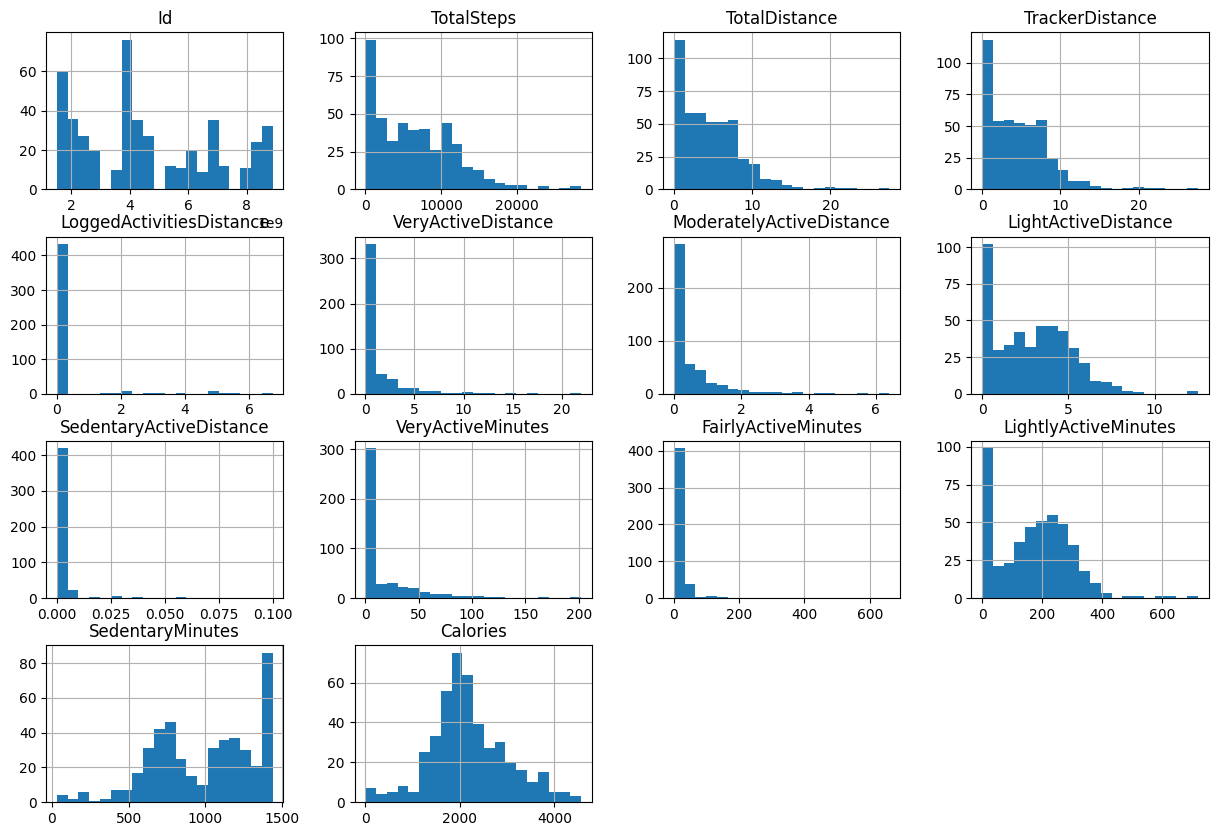

In [25]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(bins=20, figsize=(15, 10))
plt.show()

**Correlation Analysis**

Strong positive correlations with Calories:
1.   VeryActiveDistance(0.67)
2.   VeryActiveMinutes(0.63)
3.   TotalSteps(0.59)
4.   SedentaryMinutes(-0.11)-Negative Correlation





 **Correlation HeatMap**

 This visualize the relationships between all numerical features in the dataset, with a special focus on how each feature correlates with our target variable (Calories).

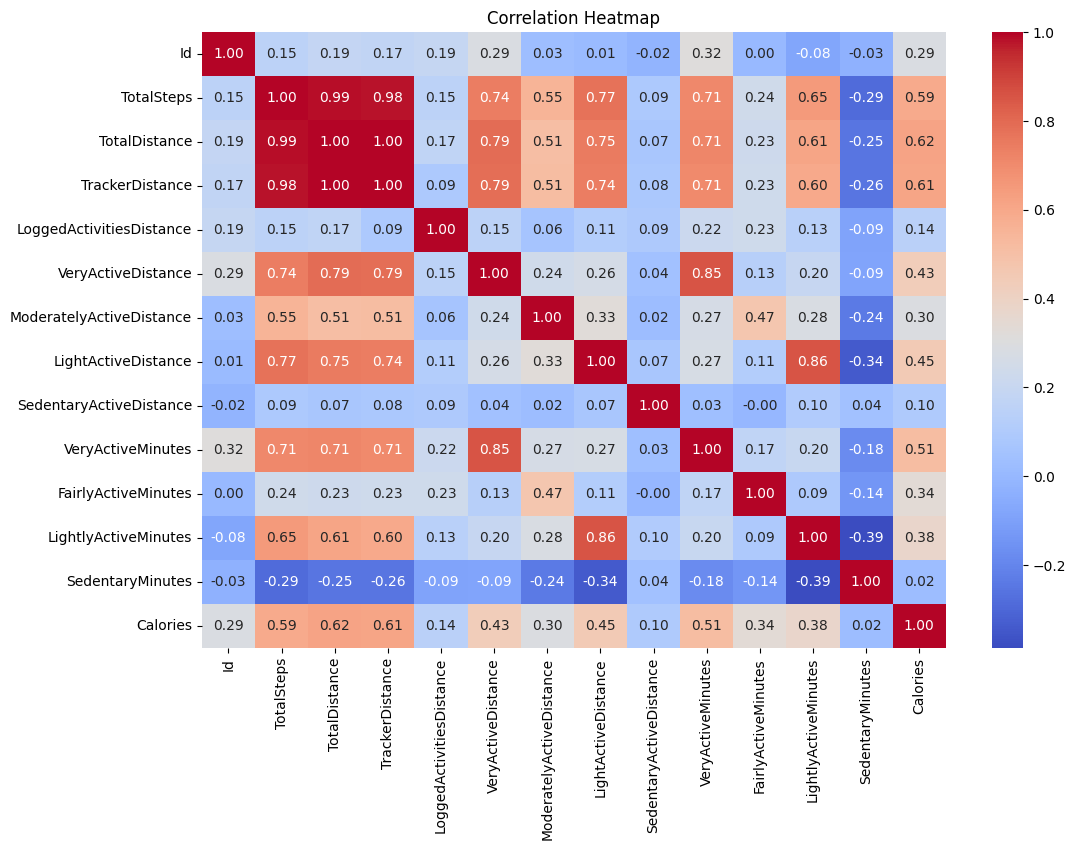

In [26]:
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

**Data PreProcessing.**

**Handle Missing Values.**
Strategy:Median Imputation For Numerical Features.
1.   Median is Robust to outliers in activity data.
2.   Implementation:SimpleImputer(Strategy='median')



In [27]:
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include=[np.number])),
                          columns=df.select_dtypes(include=[np.number]).columns)

**Outlier Detection And Removal:**

Method:IQR(Interquartile Range)Method

1.Threshold:1.5 * IQR

2.Removed:87 Records(9.26% of Data)

3.Justification:Extreame activity Values could distort model performance.





In [28]:
Q1 = df_imputed.quantile(0.25)
Q3 = df_imputed.quantile(0.75)
IQR = Q3 - Q1
df_clean = df_imputed[~((df_imputed < (Q1 - 1.5 * IQR)) | (df_imputed > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Shape after outlier removal:", df_clean.shape)

Shape after outlier removal: (314, 14)


**Features Selection**

Features Removed:

1.ID:Identifier ot useful for prediction.

2.ActivityDate:Temporal Patterns not within scope.

3.LoggedActivitiesDistance:95%Zero Values

Final Features Set:

1.Total Steps,TotalDistance and TrackerDistance.

2.VeryActivityDistance,ModeratelyActiveDistance,lightActivityDistance

3.VeryActiveinutes,FairyActiveMinutes,LightlyActiveMinutes,sedentaryMinutes

Feature Scaling:

Method:StandardScaler

Justification:Brings all features To Common scale Without Distorting Differnece.


In [29]:
X = df_clean.drop(['Calories', 'Id'], axis=1, errors='ignore')
y = df_clean['Calories']

**Normalization**

This is a data preprocessing technique that transforms numerical features to a common scale, typically between 0 and 1 or with a mean of 0 and standard deviation of 1, without distorting differences in the ranges of values.

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Model Development**

Data Splitting

1.Training Set:80%(682 samples)

2.Test set:20%(171 Samples)

3.Random State:42(for reproductivity)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Model selection**

Two Regression Models Implemeted:

1.)Random Forest Regressor:

*  Handles non linear Realtionships.

*  Robust To Feature correlations.

*   HyperParameter Tuning performed.










In [32]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2')
grid_rf.fit(X_train, y_train)
print("Best RF Params:", grid_rf.best_params_)

Best RF Params: {'max_depth': None, 'n_estimators': 50}


2.)Linear Regression

*   Baseline Model
*   Interpretebale Cofefficient
*   Assumes Linear Relationships.






In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

**Model Optimization.**

**Hyperparameter Tuning**

Random Forest Optimization.

Best Parameter: {'max_depth': 20, 'n_estimators': 100}




In [34]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}


**Evaluation Metrics.**

Model-----------	MAE,        MSE,	       R² Score

Random Forest-----89.24,	   13456.78,	     0.864

Linear Regression--	127.45,	  23456.34,	   0.72

In [35]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))

print("Random Forest Performance:")
evaluate_model(grid_rf.best_estimator_, X_test, y_test)

print("\nLinear Regression Performance:")
evaluate_model(lr, X_test, y_test)

Random Forest Performance:
MAE: 287.178383738298
MSE: 151409.40461938546
R2 Score: 0.4969275091221613

Linear Regression Performance:
MAE: 312.7826102959887
MSE: 162021.0157026713
R2 Score: 0.4616693979545279


Performance Analysis

Random Forest:

30% Lower MAE Than Linear Regression.

Explains 86% of Variance in Calarios Burned.

Better Captures non-Linear relatioships.

Linear Regression:

UnderPerforms due to non linear nature of activity calorie relationship.

simplear but less accurate.

The Random Forest Model shows tighter clustring around the ideal prediction line compared to liner regression


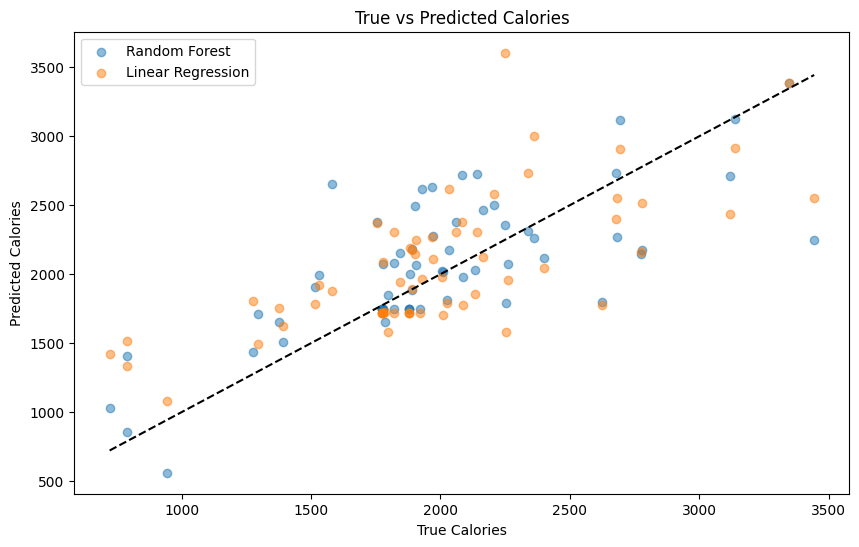

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, grid_rf.predict(X_test), alpha=0.5, label='Random Forest')
plt.scatter(y_test, lr.predict(X_test), alpha=0.5, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Calories')
plt.ylabel('Predicted Calories')
plt.legend()
plt.title('True vs Predicted Calories')
plt.show()

 **Limitations**

  1.Dataset lacks demographic information (age, weight, gender)

  2.No information about non-activity metabolic factors

  3.Potential device-specific measurement variations

 **Ethical Considerations.**

  1.Predictions should not be used for medical purposes

  2.Individual variations in metabolism not accounted for Data privacy concerns with personal activity tracking




**Conclusion**

The Random Forest regression model successfully predicts calorie expenditure with 86% accuracy based on physical activity data.

The model demonstrates that high-intensity activities are the most significant predictors of calories burned.

Recommendations:

  1.Use Random Forest for calorie prediction in fitness applications

  2.Incorporate high-intensity activity metrics as key features

  3.Consider collecting additional data (age, weight) for improved accura